In [1]:
import math
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Individual:
    def __init__(self, longitud_cromosoma, objetivos):
        self.cromosoma = [random.random() for _ in range(longitud_cromosoma)]
        self.objetivos = [0.0] * objetivos
        self.rank = None
        self.soluciones_dominadas = set()
        self.cantidad_dominados = 0


def f1(cromosoma):
    return 1 - math.exp(-sum((x - 1 / math.sqrt(7)) ** 2 for x in cromosoma))


def f2(cromosoma):
    return 1 - math.exp(-sum((x + 1 / math.sqrt(7)) ** 2 for x in cromosoma))


def cruzamiento(padre1, padre2, tasa_cruce):
    hijo1 = copy.deepcopy(padre1)
    hijo2 = copy.deepcopy(padre2)

    if random.random() < tasa_cruce:
        point = random.randint(1, len(padre1.cromosoma) - 2)
        hijo1.cromosoma[point:], hijo2.cromosoma[point:] = (
            hijo2.cromosoma[point:],
            hijo1.cromosoma[point:],
        )

    return hijo1, hijo2


def mutacion(individuo, tasa_mutacion):
    for i in range(len(individuo.cromosoma)):
        if random.random() < tasa_mutacion:
            individuo.cromosoma[i] = random.random()


def fast_non_dominated_sort(poblacion):
    fronteras = [[]]
    for ind in poblacion:
        ind.soluciones_dominadas = set()
        ind.cantidad_dominados = 0
        for individual in poblacion:
            if ind == individual:
                continue
            if dominantes(ind, individual):
                ind.soluciones_dominadas.add(individual)
            elif dominantes(individual, ind):
                ind.cantidad_dominados += 1
        if ind.cantidad_dominados == 0:
            ind.rank = 0
            fronteras[0].append(ind)

    i = 0
    while fronteras[i]:
        nueva_frontera = []
        for ind in fronteras[i]:
            for dominado in ind.soluciones_dominadas:
                dominado.cantidad_dominados -= 1
                if dominado.cantidad_dominados == 0:
                    dominado.rank = i + 1
                    nueva_frontera.append(dominado)
        i += 1
        fronteras.append(nueva_frontera)

    return fronteras[:-1]


def crowding_distance_assignment(frontera):
    lista_distancias = [0.0] * len(frontera)
    objetivos = len(frontera[0].objetivos)

    for m in range(objetivos):
        frontera.sort(key=lambda x: x.objetivos[m])
        lista_distancias[0] = lista_distancias[-1] = float("inf")
        valor_min_objetivo = min(ind.objetivos[m] for ind in frontera)
        valor_max_objetivo = max(ind.objetivos[m] for ind in frontera)

        if valor_max_objetivo == valor_min_objetivo:
            continue

        for i in range(1, len(frontera) - 1):
            lista_distancias[i] += (
                frontera[i + 1].objetivos[m] - frontera[i - 1].objetivos[m]
            ) / (valor_max_objetivo - valor_min_objetivo)

    for i, ind in enumerate(frontera):
        ind.crowding_distance = lista_distancias[i]


def dominantes(ind1, ind2):
    return all(x <= y for x, y in zip(ind1.objetivos, ind2.objetivos)) and any(
        x < y for x, y in zip(ind1.objetivos, ind2.objetivos)
    )


def nsga2(population_size, generaciones, tasa_cruce, tasa_mutacion):
    longitud_cromosoma = 10
    objetivos = 2

    poblacion = [
        Individual(longitud_cromosoma, objetivos) for _ in range(population_size)
    ]

    for ind in poblacion:
        ind.objetivos[0] = f1(ind.cromosoma)
        ind.objetivos[1] = f2(ind.cromosoma)

    # Inicializar el mejor individuo con valores objetivo infinitos
    mejor_individuo = Individual(longitud_cromosoma, objetivos)
    mejor_individuo.objetivos = [float("inf")] * objetivos

    for generation in range(generaciones):
        offspring = []
        for _ in range(population_size):
            padre1 = random.choice(poblacion)
            padre2 = random.choice(poblacion)
            hijo1, hijo2 = cruzamiento(padre1, padre2, tasa_cruce)
            mutacion(hijo1, tasa_mutacion)
            mutacion(hijo2, tasa_mutacion)
            hijo1.objetivos[0] = f1(hijo1.cromosoma)
            hijo1.objetivos[1] = f2(hijo1.cromosoma)
            hijo2.objetivos[0] = f1(hijo2.cromosoma)
            hijo2.objetivos[1] = f2(hijo2.cromosoma)
            offspring.extend([hijo1, hijo2])

        poblacion_combinada = poblacion + offspring
        fronteras = fast_non_dominated_sort(poblacion_combinada)

        nueva_poblacion = []
        sobrante_size = population_size
        i = 0

        while sobrante_size > 0 and fronteras[i]:
            if len(fronteras[i]) <= sobrante_size:
                nueva_poblacion.extend(fronteras[i])
                sobrante_size -= len(fronteras[i])
            else:
                crowding_distance_assignment(fronteras[i])
                fronteras[i].sort(key=lambda x: x.crowding_distance, reverse=True)
                nueva_poblacion.extend(fronteras[i][:sobrante_size])
                sobrante_size = 0
            i += 1

        poblacion = nueva_poblacion

        # Actualizar el mejor individuo encontrado
        for ind in poblacion:
            if (
                ind.objetivos[0] < mejor_individuo.objetivos[0]
                and ind.objetivos[1] < mejor_individuo.objetivos[1]
            ):
                mejor_individuo = ind

    return poblacion, mejor_individuo


def plot_frontera_pareto(poblacion, f1, f2):
    f1_values = [f1(ind) for ind in poblacion]
    f2_values = [f2(ind) for ind in poblacion]

    plt.scatter(f1_values, f2_values, c="blue", marker="o", label="Frontera de Pareto")
    plt.xlabel("Objetivo 1")
    plt.ylabel("Objetivo 2")
    plt.title("Frontera de Pareto para el NSGA-II")
    plt.legend()
    plt.grid()
    plt.show()

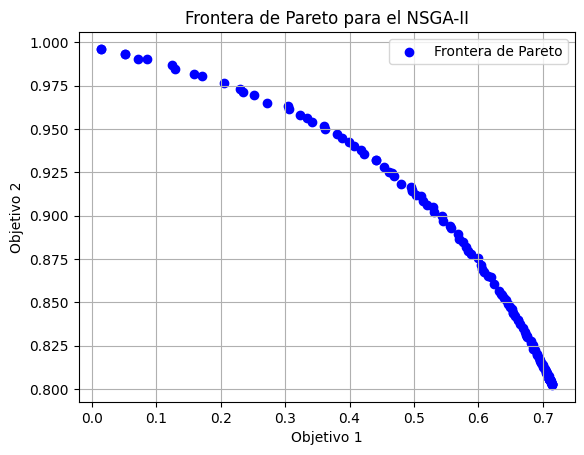

Mejor individuo encontrado:
Cromosoma: [0.27724300212857533, 0.2206224656198379, 0.3315148418447348, 0.26384012752255814, 0.34965584915399683, 0.24952409889877614, 0.22945772864036507, 0.28674928620729334, 0.23506258118189638, 0.20833532460442783]
Objetivos: [0.13666374297131922, 0.9843362503799887]
---------------------------------------
Objetivos: [0.7146980975374604, 0.8023398355402208]
---
Objetivos: [0.014604274648504778, 0.9961349396999223]
---
Objetivos: [0.7120554240893882, 0.8043250914794802]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7140853781749132, 0.8026444063225484]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7140853781749132, 0.8026444063225484]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7112744780438858, 0.8049532247137042]
---
Objetivos: [0.7112744780438858, 0.8049532

In [3]:
if __name__ == "__main__":
    population_size = 150
    generaciones = 100
    tasa_cruce = 0.9
    tasa_mutacion = 0.1

    final_population, mejor_individuo = nsga2(
        population_size, generaciones, tasa_cruce, tasa_mutacion
    )
    plot_frontera_pareto(
        final_population, lambda ind: ind.objetivos[0], lambda ind: ind.objetivos[1]
    )
    print("Mejor individuo encontrado:")
    print("Cromosoma:", mejor_individuo.cromosoma)
    print("Objetivos:", mejor_individuo.objetivos)
    print("---------------------------------------")
    for ind in final_population:
        # print("Cromosoma:", ind.cromosoma)
        print("Objetivos:", ind.objetivos)
        print("---")